## Be sure you have Praat loaded! (module load praat)

In [2]:
#!/usr/bin/env python
# coding: utf-8

import pydub
import parselmouth
from pydub.silence import detect_nonsilent
from pydub import AudioSegment
from multiprocessing import Pool
from collections import defaultdict
from timeit import default_timer as timer
import glob, os, pickle, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

num_processors = 28
base_path='/project2/mbspencer/nih/data/'
#zone='Zone '+str(sys.argv[1])

# Start timer
#start = timer()
zone = 'Zone 1'
date = '2018_08_05'

In [3]:
def draw_spectrogram(spect, dynamic_range=70):
    X, Y = spect.x_grid(), spect.y_grid()
    sg_db = 10*np.log10(spect.values)
    min_db = sg_db.max() - dynamic_range
    plt.pcolormesh(X, Y, sg_db, vmin=min_db, cmap='afmhot')
    plt.ylim([spect.ymin, spect.ymax])
    plt.xlabel("time [s]")
    plt.ylabel("frequency [Hz]")

def draw_pitch(pitch):
    # Extract selected pitch countour, and
    # replace uncoivced samples by NaN to not plot
    pitch_values = pitch.selected_array['frequency']
    pitch_values[pitch_values==0] = np.nan
    plt.plot(pitch.xs(), pitch_values, 'o', markersize = 5, color = '2')
    plt.plot(pitch.xs(), pitch_values, 'o', markersize = 2)
    plt.grid(False)
    plt.ylim(0, pitch.ceiling)
    plt.ylabel("fundamental frequency [Hz]")

In [4]:
# Create a dictionary {mp3_file:AudioSegment.from_mp3(mp3_file)}
def get_mp3_file(mp3_file):
    return {mp3_file.split('/')[-1]:AudioSegment.from_mp3(mp3_file)}

In [5]:
# Helper function to convert pydub to numpy array (for parselmouth)
def pydub_to_np(audio):
    """Converts pydub audio segment into float32 np array of shape [channels, duration_in_seconds*sampling_rate],
    where each value is in range [-1.0, 1.0]. Returns tuple (audio_np_array, sample_rate)"""
    # get_array_of_samples returns the data in format:
    # [sample_1_channel_1, sample_1_channel_2, sample_2_channel_1, ...]
    # where samples are integers of sample_width bytes.
    return np.array(audio.get_array_of_samples(), dtype=np.float64).reshape((-1, audio.channels)).T / (1<<(8*audio.sample_width)), audio.frame_rate

In [6]:
# Load audio files
def load_audio(files,num_processors=num_processors):
    files.sort()
    p = Pool(processes = num_processors)
    output = p.map(get_mp3_file,files)
    p.close()
    audio_dict = {k:v for i in output for k,v in i.items()}
    return audio_dict

In [7]:
audio_path = base_path + zone.replace(' ','') + '/' + date + '/'
files = glob.glob(audio_path+'2*.mp3')
audio_dict = load_audio(files)

In [8]:
sound = audio_dict['201808042331-339616-27730.mp3']
samples, sample_rate = pydub_to_np(sound)

In [9]:
samples[0], sample_rate

(array([ 0.        ,  0.        ,  0.        , ..., -0.00032043,
        -0.00028992, -0.00027466]),
 22050)

In [12]:
snd = parselmouth.Sound(samples[0], sample_rate)
pitch = snd.to_pitch_ac(time_step=0.005, max_number_of_candidates=5000)

In [33]:
len(pitch)

366234

In [36]:
len(pitch.to_array())

39

In [37]:
pickle.dump(pitch.to_array(),open(audio_path+'pkl_pitch.pkl','wb'))

In [13]:
intensity = snd.to_intensity()

In [23]:
intensity.as_array()[0]

array([-300.        , -300.        , -300.        , ...,   19.65362388,
         19.60577481,   19.77549332])

In [32]:
pd.Series(intensity.as_array()[0]).to_csv(audio_path+'test_intensity.csv',index=False)

In [28]:
#snd.pre_emphasize()
spectrogram = snd.to_spectrogram(maximum_frequency=8000.0, frequency_step=20.0)
pd.DataFrame(spectrogram.as_array().T)

,0,1,2,3,4,5,6,7,8,9,...,175,176,177,178,179,180,181,182,183,184
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915595,0.000015,0.000014,0.000011,0.000007,0.000005,2.510361e-06,1.389120e-06,8.381189e-07,5.709971e-07,4.180690e-07,...,5.996883e-11,4.994167e-11,4.222128e-11,3.780492e-11,3.638765e-11,3.678959e-11,3.772059e-11,3.833062e-11,3.848017e-11,3.879359e-11
915596,0.000017,0.000016,0.000014,0.000010,0.000007,4.566552e-06,2.907287e-06,1.880889e-06,1.232523e-06,7.765588e-07,...,1.806750e-11,2.026489e-11,1.712093e-11,1.088861e-11,4.973555e-12,1.617326e-12,1.305417e-12,3.722372e-12,8.727829e-12,1.628805e-11
915597,0.000007,0.000006,0.000005,0.000003,0.000001,6.315512e-07,5.921525e-07,8.224590e-07,1.040572e-06,1.126708e-06,...,5.205503e-11,5.118262e-11,4.518367e-11,3.602659e-11,2.630267e-11,1.822778e-11,1.298922e-11,1.060962e-11,1.024995e-11,1.073287e-11
915598,0.000008,0.000008,0.000006,0.000005,0.000003,1.848415e-06,1.056369e-06,5.772283e-07,2.986865e-07,1.370840e-07,...,1.487534e-11,1.263920e-11,1.048130e-11,9.398167e-12,9.843067e-12,1.128255e-11,1.252391e-11,1.251218e-11,1.098984e-11,8.716533e-12


In [29]:
df_test = pd.DataFrame(spectrogram.as_array().T)
df_test.to_csv(audio_path+'test_spectrogram.csv',index=False)

In [115]:
len(snd)/len(spectrogram)

44.10023591087811

In [113]:
len(snd)/183117

220.50479201821787

In [96]:
df_pitch = pd.DataFrame(columns=['frequency','strength'])
pitch_array = pitch.to_array()
for i in range(len(pitch_array)):
    df_pitch.append(pd.DataFrame(pitch_array[i]))
len(df_pitch)

0

In [99]:
pd.DataFrame(pitch_array[0])

,frequency,strength
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0
...,...,...
183112,0.0,0.0
183113,0.0,0.0
183114,0.0,0.0
183115,0.0,0.0


In [92]:
pd.DataFrame(pitch.to_array()[0]).describe()

,frequency,strength
count,183117.000000,183117.000000
mean,24.486739,0.099604
std,72.998645,0.267920
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,599.968348,0.999608


In [93]:
pd.DataFrame(pitch.to_array()[1]).describe()

,frequency,strength
count,178117.000000,178117.000000
mean,985.963141,0.474595
std,863.762678,0.242795
min,0.000000,0.000000
25%,120.077255,0.277811
50%,941.054681,0.354239
75%,1404.291274,0.758973
max,9327.817815,0.999329


In [94]:
pd.DataFrame(pitch.to_array()[2]).describe()

,frequency,strength
count,127517.000000,127517.000000
mean,441.224066,0.475814
std,493.747281,0.246193
min,0.000000,0.000000
25%,120.019128,0.267740
50%,145.049073,0.353525
75%,587.118779,0.760535
max,3087.108752,0.997583


In [87]:
pitch.to_array()

array([[(   0.        , 0.        ), (   0.        , 0.        ),
        (   0.        , 0.        ), ..., (   0.        , 0.        ),
        (   0.        , 0.        ), (   0.        , 0.        )],
       [(          nan,        nan), (          nan,        nan),
        (          nan,        nan), ..., (1837.21013016, 0.41588606),
        (1841.53762512, 0.3473095 ), (1871.24101376, 0.36899292)],
       [(          nan,        nan), (          nan,        nan),
        (          nan,        nan), ..., (1339.93392849, 0.3880012 ),
        (1335.12210353, 0.31416412), (1339.37598476, 0.30552827)],
       ...,
       [(          nan,        nan), (          nan,        nan),
        (          nan,        nan), ..., (          nan,        nan),
        (          nan,        nan), (          nan,        nan)],
       [(          nan,        nan), (          nan,        nan),
        (          nan,        nan), ..., (          nan,        nan),
        (          nan,        nan)

In [80]:
pitch.to_matrix()

/home/graziul/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


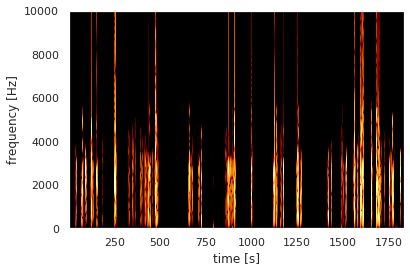

In [43]:
plt.figure()
draw_spectrogram(spectrogram)

In [48]:
spectrogram.get_frame_number_from_time(1)
spectrogram.to_spectrum_slice(498)

In [44]:
plt.figure()
draw_pitch(pitch)
plt.xlim([snd.xmin, snd.xmax])
plt.show()

ValueError: Invalid string grayscale value '2'. Value must be within 0-1 range

<Figure size 432x288 with 1 Axes>

In [37]:
plt.figure()
draw_spectrogram(spectrogram)
plt.twinx()
draw_pitch(pitch)
plt.xlim([snd.xmin, snd.xmax])
plt.show()

/home/graziul/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


ValueError: Invalid string grayscale value '2'. Value must be within 0-1 range

<Figure size 432x288 with 2 Axes>